In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np
import math


print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [43]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (10e-6))**20)
    dz = torch.abs(z[1] - z[0])
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

# GX_11

You are given a fibre with the parameters written below. 
Try to launch fundamental modes into the fibre. For simplicity, assume that the fundamental modes can be expressed as 

$$f_n(x) = \begin{cases}
\cos\left(\frac{n\pi x}{2r_{\text{core}}}\right) & \text{if } -r_{\text{core}} \leq x \leq r_{\text{core}} \\
0 & \text{otherwise}
\end{cases}$$
for $n \in {1,3,5, ...}$ and
$$f_n(x) = \begin{cases}
\sin\left(\frac{n\pi x}{2r_{\text{core}}}\right) & \text{if } -r_{\text{core}} \leq x \leq r_{\text{core}} \\
0 & \text{otherwise}
\end{cases}$$
for $n \in {2,4,6, ...}$


The $V$ number of the waveguide and the number of modes can be expressed as:
$$V = \frac{2\pi}{\lambda} \cdot (2r_{\text{core}}) \cdot \sqrt{n_{\text{core}}^2 - n_{\text{cladding}}^2}$$
$$\text{number\_modes} = \frac{V}{\pi} + 0.5$$


Tasks:
- Calculate how many modes are supported.
- Show numerically that only those modes propagate without significant losses.
- Give some reasoning why higher order modes are not supported.

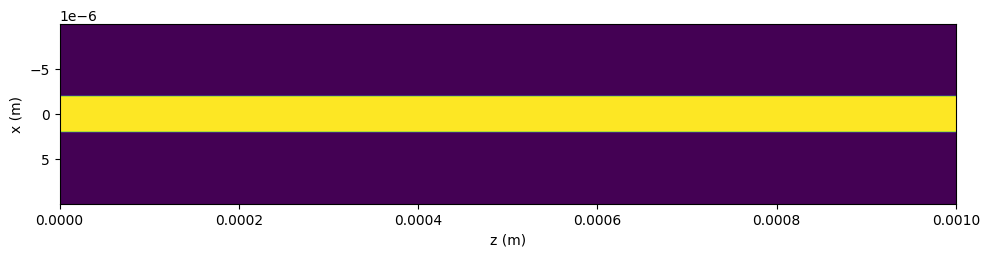

In [49]:
N = 100
Nz = 1000
refractive_index = torch.zeros(N, Nz)
wvl = 633e-9

x = torch.linspace(-10e-6, 10e-6, refractive_index.shape[0])
z = torch.linspace(0e-6, 1_000e-6, Nz)


r_core = 2e-6
n_core = 1.02
n_cladding = 1.0


refractive_index[:, :] = (n_core - n_cladding) * ((torch.abs(x) < r_core)).reshape(N, 1)
# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(refractive_index.cpu().numpy(), 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=10,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

In [50]:

V = (2 * math.pi / wvl) * (2 * r_core) * math.sqrt(n_core**2 - n_cladding**2)
num_modes = V / math.pi + 0.5

print(f"V = {V:.2f}")
print(f"Number of modes = {num_modes:.2f}")
print(f"Number of modes (rounded) = {int(num_modes)}")
num_modes = int(num_modes)


V = 7.98
Number of modes = 3.04
Number of modes (rounded) = 3


In [51]:
def mode_fn(n, x, r_core):
    inside_core = torch.abs(x) <= r_core
    x_core = x[inside_core]
    f = torch.zeros_like(x)

    if n % 2 == 1:
        f_core = torch.cos(n * math.pi * x_core / (2 * r_core))
    else:
        f_core = torch.sin(n * math.pi * x_core / (2 * r_core))
    
    f[inside_core] = f_core
    return f / torch.norm(f)  # normalize


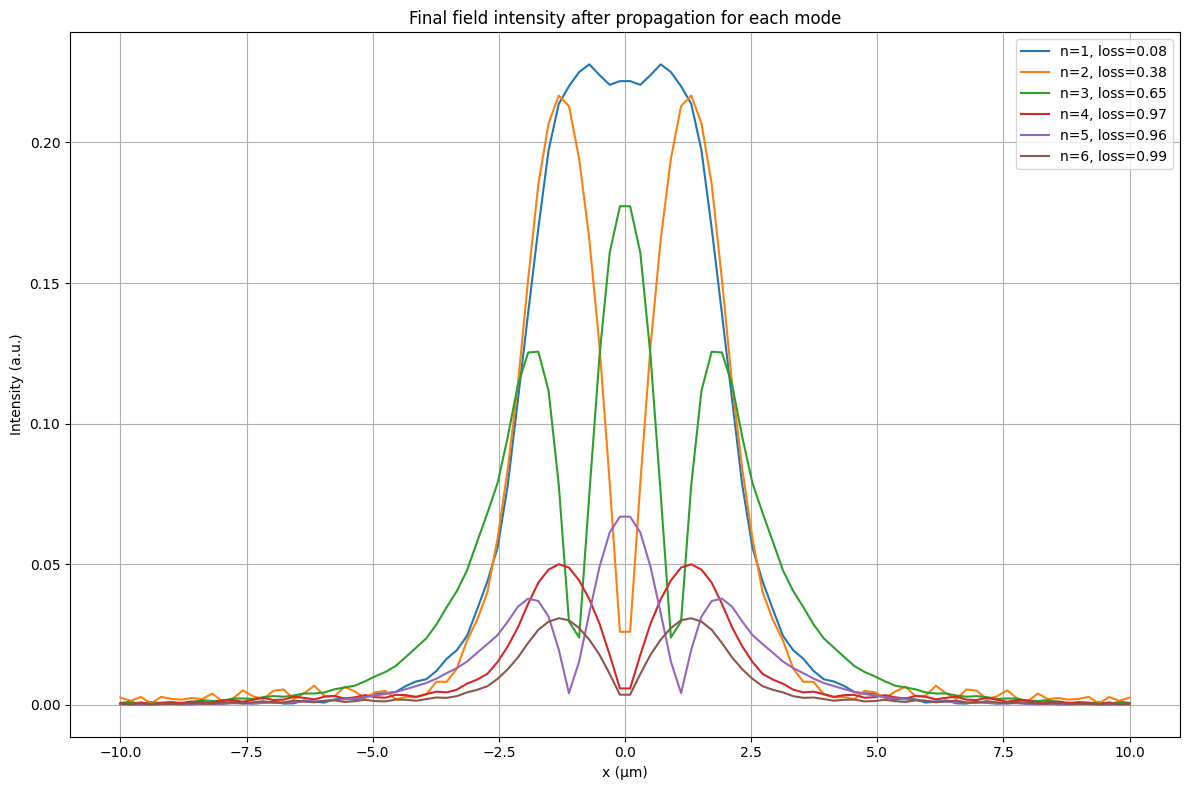

Supported modes: [1, 2, 3]


In [52]:
supported_modes = []

plt.figure(figsize=(12, 8))
for n in range(1, num_modes + 4):  # try a bit beyond expected to show cutoff
    U0 = mode_fn(n, x, r_core).to(device)
    U_prop = fibre_propagation(U0, wvl, x.to(device), z.to(device), refractive_index.to(device))
    final_intensity = torch.abs(U_prop[:, -1])

    # Measure power loss
    loss = 1-torch.sum(final_intensity**2) / torch.sum(torch.abs(U0)**2)

    plt.plot(x.cpu()*1e6, final_intensity.cpu(), label=f"n={n}, loss={loss:.2f}")

    if loss < 0.7:  # arbitrarily cutoff at 70% power loss
        supported_modes.append(n)

plt.title("Final field intensity after propagation for each mode")
plt.xlabel("x (µm)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Supported modes:", supported_modes)


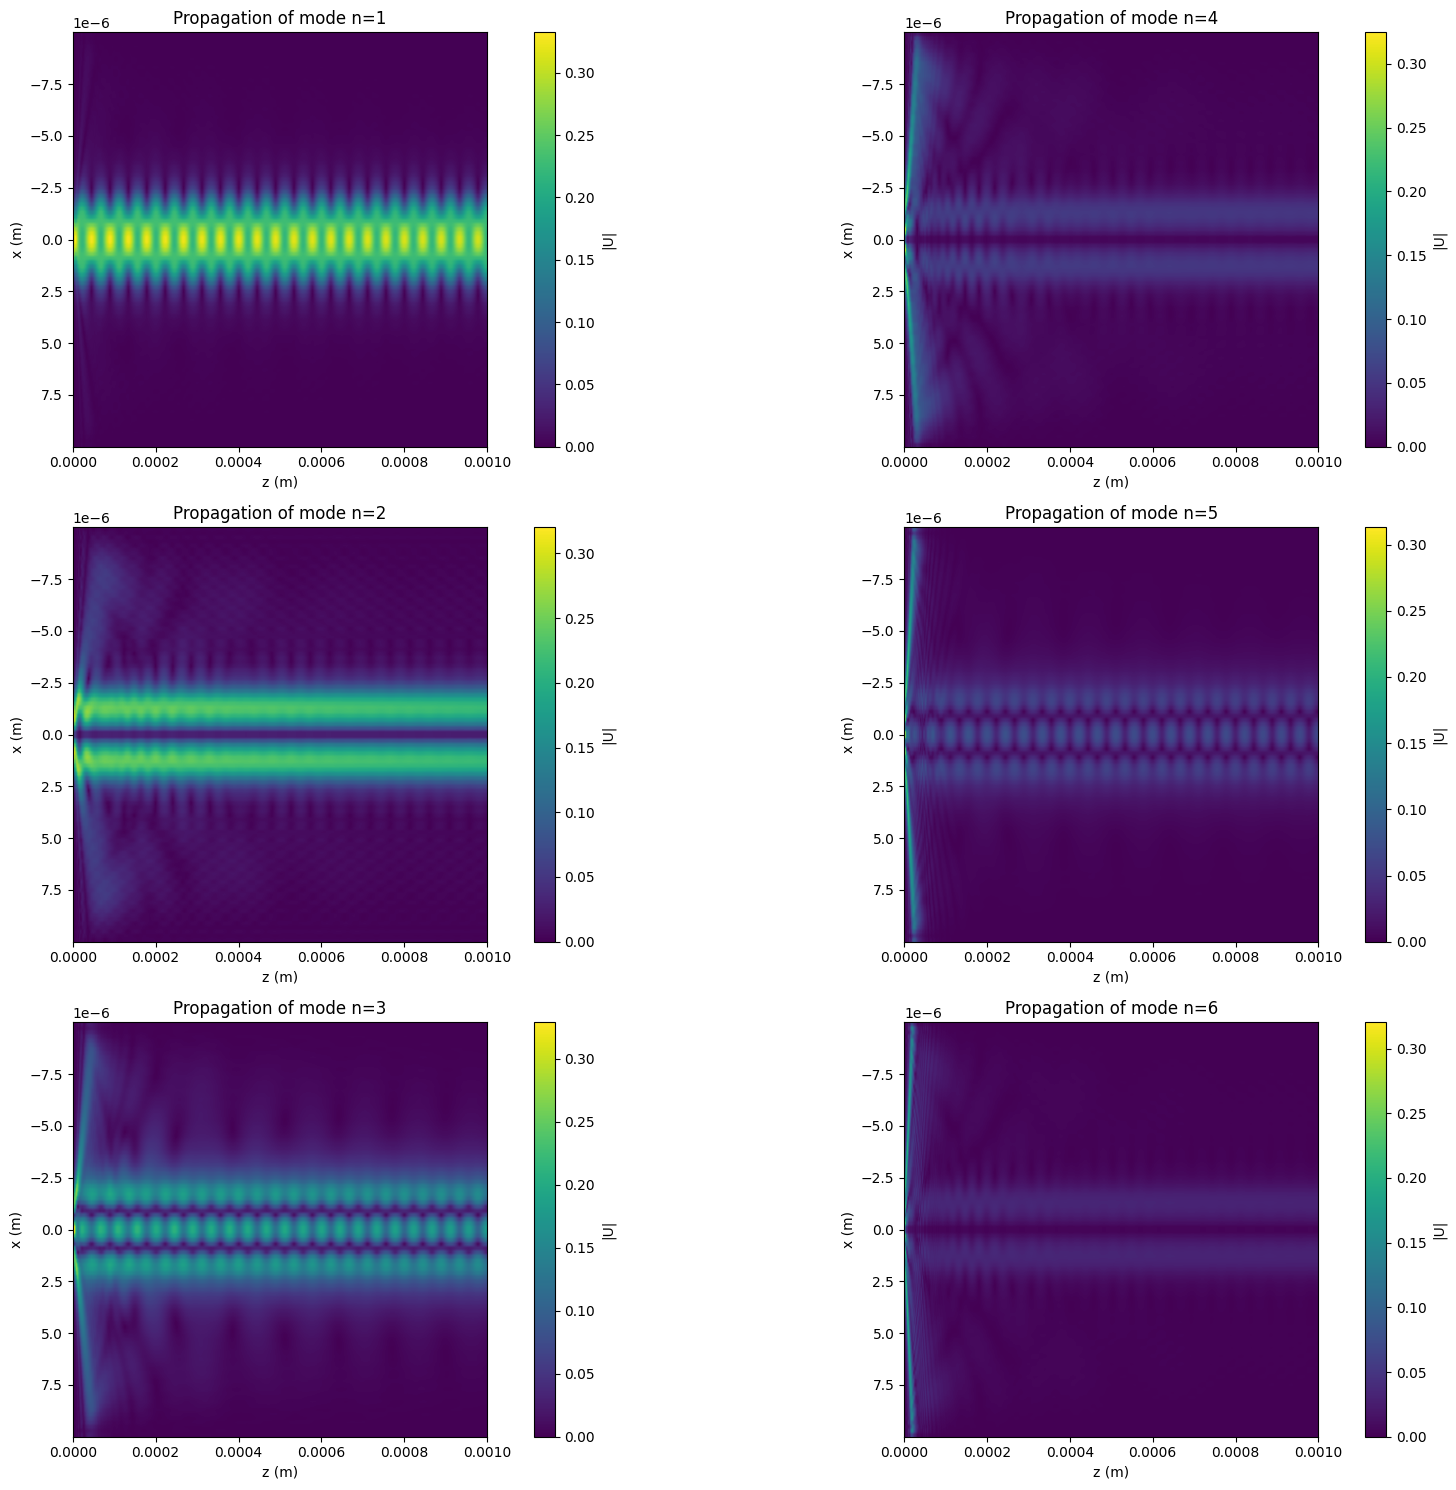

In [53]:
plt.figure(figsize=(18, 15))
for idx, n_mode in enumerate(range(1, 7), 1):
    U0_mode = mode_fn(n_mode, x, r_core).to(device)
    U_prop_mode = fibre_propagation(U0_mode, wvl, x.to(device), z.to(device), refractive_index.to(device))
    col = 0 if n_mode <= 3 else 1
    row = n_mode - 1 if n_mode <= 3 else n_mode - 4
    
    plt.subplot(3, 2, col + 1 + row * 2)
    plt.imshow(torch.abs(U_prop_mode).cpu().numpy(),
               extent=[z[0], z[-1], x[-1], x[0]],
               aspect=50,
               cmap='viridis')
    plt.title(f"Propagation of mode n={n_mode}")
    plt.xlabel("z (m)")
    plt.ylabel("x (m)")
    plt.colorbar(label="|U|")
    
plt.tight_layout()
plt.show()

We can see that only the modes 1,2 and 3 still have a significant power after the propagation.

Higher-order modes are not supported in this fiber because the V-number is low. Since the V-number depends on the core radius, increasing the core size would allow more modes to propagate.

Higher-order modes have higher spatial frequencies, which causes their fields to extend further into the cladding. As a result, they are less confined and more strongly affected by the absorbing window, leading to rapid power loss during propagation.

Verifying with the plots above (right column), we can see that the evanescent tails have much more intensity than in the left column, confirming that the energy goes mainly outside of the cladding.